In [18]:
import glob
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [19]:
classes = [
    'worm eaten',
    'Mold',
    'defecation',
    'brown spot',
    'Water stains',
]

# calculate global label distribution

In [20]:
# calculate distribution

# of class
cal = np.zeros(5, dtype='int')

# of bbox width and height
bbox_wh = {
    '0':[],
    '1':[],
    '2':[],
    '3':[],
    '4':[],
}

In [21]:
labels = glob.glob('yolo/*.txt')

In [22]:
# read label file
for label in tqdm(labels):
    f = open(label)
    lines = f.readlines()
    
    # parse class
    for line in lines:
        if len(line.split(' ')) > 1:
            cal[int(line.split(' ')[1])] += 1
            bbox_wh[line.split(' ')[1]].append([float(line.split(' ')[4]), float(line.split(' ')[5][:-1])])

100%|██████████| 333/333 [00:00<00:00, 2124.53it/s]


In [23]:
cal

array([ 7931,  6798,   949, 16891,   582])

In [46]:
# bbox width & height (mean, std)

for i in range(5):
    dist = [*(np.array(bbox_wh[str(i)])*608).mean(axis=0), *(np.array(bbox_wh[str(i)])*608).std(axis=0)]
    print('class {} :\tw = {}(+-{}), h = {}(+-{})'.format(classes[i], dist[0], dist[2], dist[1], dist[3]))


class worm eaten :	w = 6.43184862640271(+-11.843007558113435), h = 9.19338408977457(+-14.77052846617445)
class Mold :	w = 2.8547264442484015(+-4.426548838473719), h = 4.463042334804193(+-8.415624234478793)
class defecation :	w = 9.589616252897791(+-13.532072792161463), h = 18.479046507903067(+-47.447032699059314)
class brown spot :	w = 4.252203014623243(+-7.865672925728667), h = 5.712240881889928(+-7.402302501987947)
class Water stains :	w = 46.318688384879735(+-51.885852786523856), h = 62.89083260481102(+-75.40290283163195)


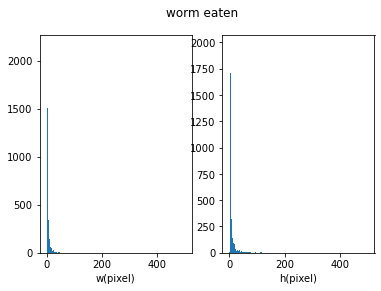

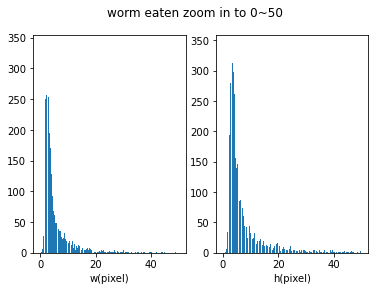

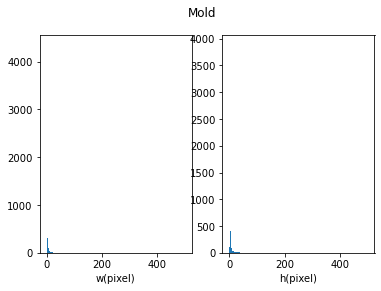

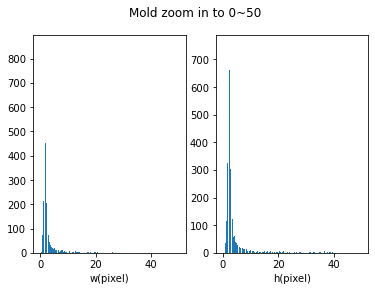

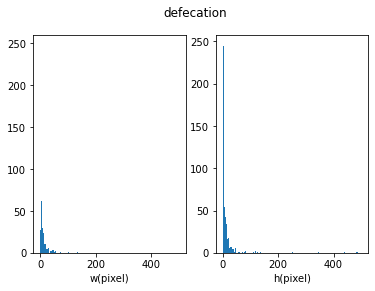

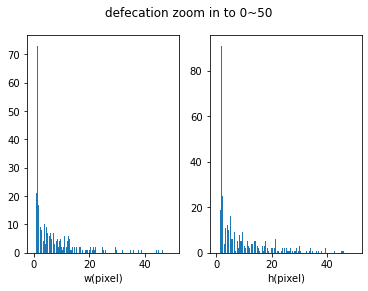

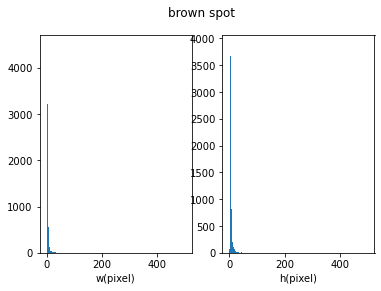

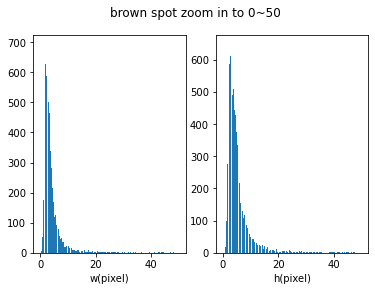

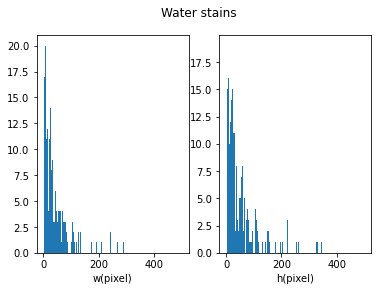

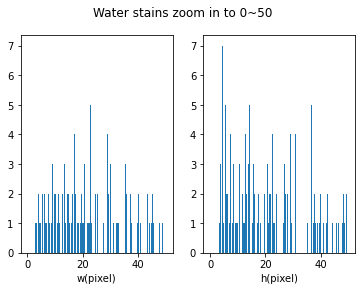

In [64]:
# bbox hist
# bbox size if resize to 608*608

for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(classes[i])
    ax1.hist((np.array(bbox_wh[str(i)])*608).T[0], bins=500, range=(0, 500))
    ax1.set(xlabel='w(pixel)')
    ax2.hist((np.array(bbox_wh[str(i)])*608).T[1], bins=400, range=(0, 500))
    ax2.set(xlabel='h(pixel)')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(classes[i] + " zoom in to 0~50")
    ax1.hist((np.array(bbox_wh[str(i)])*608).T[0], bins=500, range=(0, 50))
    ax1.set(xlabel='w(pixel)')
    ax2.hist((np.array(bbox_wh[str(i)])*608).T[1], bins=400, range=(0, 50))
    ax2.set(xlabel='h(pixel)')

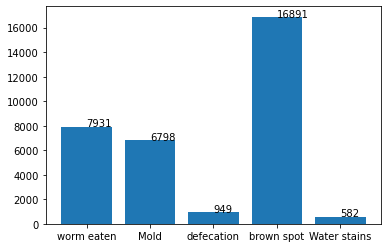

In [58]:
# class distribution

plt.bar(range(5), cal, tick_label=classes)

# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
for index, data in enumerate(cal):
    plt.text(x=index , y=data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

# train label distributions

In [86]:
f = open('mytrain.txt')

In [87]:
raw_files = f.readlines()
labels = []

In [88]:
# read yolo train split file
for file in tqdm(raw_files):
    _file = file.split('/')[-1]
    labels.append(os.path.join('yolo', _file[:-4] + 'txt'))

100%|██████████| 219/219 [00:00<00:00, 101880.28it/s]


In [89]:
# calculate distribute

cal = np.zeros(5, dtype='int')

In [90]:
# read label file
for label in tqdm(labels):
    f = open(label)
    lines = f.readlines()
    
    # parse class
    for line in lines:
        if len(line.split(' ')) > 1:
            cal[int(line.split(' ')[1])] += 1

100%|██████████| 219/219 [00:00<00:00, 4244.01it/s]


In [91]:
cal

array([3515, 3890,  576, 8976,  375])

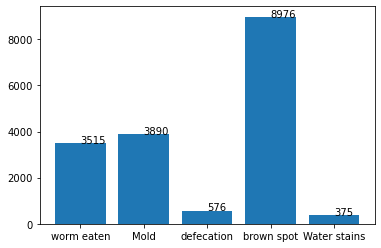

In [92]:
plt.bar(range(5), cal, tick_label=classes)

# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
for index, data in enumerate(cal):
    plt.text(x=index , y=data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

# valid label distributions

In [93]:
f = open('myvalid.txt')

In [94]:
raw_files = f.readlines()
labels = []

In [95]:
# read yolo train split file
for file in tqdm(raw_files):
    _file = file.split('/')[-1]
    labels.append(os.path.join('yolo', _file[:-4] + 'txt'))

100%|██████████| 110/110 [00:00<00:00, 53436.81it/s]


In [96]:
# calculate distribute

cal = np.zeros(5, dtype='int')

In [97]:
# read label file
for label in tqdm(labels):
    f = open(label)
    lines = f.readlines()
    
    # parse class
    for line in lines:
        if len(line.split(' ')) > 1:
            cal[int(line.split(' ')[1])] += 1

100%|██████████| 110/110 [00:00<00:00, 2736.90it/s]


In [98]:
cal

array([4375, 2645,  373, 6394,  207])

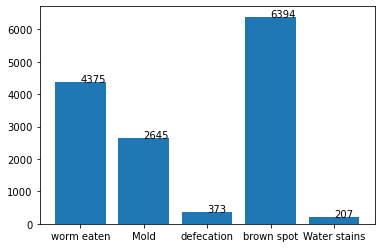

In [99]:
plt.bar(range(5), cal, tick_label=classes)

# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
for index, data in enumerate(cal):
    plt.text(x=index , y=data+1 , s=f"{data}" , fontdict=dict(fontsize=10))